In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xrp_open.csv')
print(df)

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

# df.to_csv("/BOOSTING/bitcoin_processed_close.csv")
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,0.322593,0.317439,0.321078,0.320790,363940431,0.320790,0.005154,0.326430,0.333398,0.343423,0.004046,0.019639
21,21,2019-01-22,0.321078,0.313455,0.319566,0.319491,434125854,0.319491,0.007623,0.325376,0.330090,0.341227,0.004784,0.019605
22,22,2019-01-23,0.320303,0.314923,0.316416,0.316492,375671478,0.316492,0.005380,0.323480,0.326158,0.338461,0.005382,0.018754
23,23,2019-01-24,0.318896,0.314433,0.317859,0.317598,344960253,0.317598,0.004463,0.321860,0.325199,0.336466,0.005072,0.018603
24,24,2019-01-25,0.319069,0.313824,0.317260,0.317165,360076505,0.317165,0.005245,0.320654,0.324074,0.334605,0.005010,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,0.390547,0.374133,0.378507,0.378477,953355531,0.378477,0.016414,0.390655,0.387824,0.390458,0.006728,0.010027
1516,1516,2023-02-25,0.379419,0.372250,0.378085,0.378085,552223148,0.378085,0.007169,0.388296,0.387403,0.388878,0.007907,0.009161
1517,1517,2023-02-26,0.380606,0.375420,0.378005,0.378041,441815645,0.378041,0.005186,0.387100,0.387600,0.387880,0.008825,0.009149
1518,1518,2023-02-27,0.380042,0.372158,0.379121,0.379115,1049508853,0.379115,0.007884,0.384329,0.388137,0.387227,0.007603,0.009266


In [4]:
pre_day =7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','close','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

150
(1343, 7, 9) (1343, 1) (150, 7, 9) (150, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_open.h5")

Epoch 1/120
40/40 [==============================] - 10s 13ms/step - loss: 0.0108
Epoch 2/120
40/40 [==============================] - 1s 15ms/step - loss: 0.0046
Epoch 3/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 4/120
40/40 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 5/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 6/120
40/40 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 7/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0033
Epoch 8/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 9/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 10/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0027
Epoch 11/120
40/40 [==============================] - 1s 26ms/step - loss: 0.0030
Epoch 12/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

42/42 [==============================] - 2s 3ms/step
      predict_price  y_train_price  error_price
0          0.308013       0.295060     0.012953
1          0.296021       0.289425     0.006596
2          0.289608       0.320704    -0.031096
3          0.315304       0.310839     0.004465
4          0.310633       0.308326     0.002307
...             ...            ...          ...
1338       0.469712       0.448636     0.021076
1339       0.457745       0.450594     0.007151
1340       0.437488       0.485435    -0.047947
1341       0.482342       0.479822     0.002520
1342       0.473788       0.475119    -0.001331

[1343 rows x 3 columns]


In [7]:
import pickle
from sklearn.linear_model import ElasticNet

elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_open.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

5/5 [==============================] - 0s 4ms/step
[[0.19555682]
 [0.18372104]
 [0.18647972]
 [0.19528131]
 [0.20155048]
 [0.20648135]
 [0.21877515]
 [0.22145744]
 [0.22801957]
 [0.2109353 ]
 [0.20137286]
 [0.20329781]
 [0.19337204]
 [0.20451193]
 [0.19617695]
 [0.19133955]
 [0.19188035]
 [0.18852702]
 [0.18046026]
 [0.17789723]
 [0.17948557]
 [0.18462166]
 [0.18503681]
 [0.17931914]
 [0.18207853]
 [0.18516447]
 [0.18445668]
 [0.1873382 ]
 [0.18887575]
 [0.18243459]
 [0.18281993]
 [0.18296199]
 [0.17847054]
 [0.17913061]
 [0.20570068]
 [0.20192635]
 [0.1917173 ]
 [0.18835151]
 [0.1561391 ]
 [0.12501454]
 [0.14337406]
 [0.1376565 ]
 [0.1302237 ]
 [0.11871579]
 [0.12792684]
 [0.14222103]
 [0.1337454 ]
 [0.13781631]
 [0.13953945]
 [0.14062576]
 [0.12966159]
 [0.12673683]
 [0.13271745]
 [0.13577482]
 [0.14860088]
 [0.1536981 ]
 [0.14943284]
 [0.14937034]
 [0.14221819]
 [0.14753123]
 [0.15239045]
 [0.14827281]
 [0.14492807]
 [0.14365527]
 [0.14378357]
 [0.14292432]
 [0.14266534]
 [0.1385130

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[0.4706312 ]
 [0.45054877]
 [0.45522958]
 [0.4701638 ]
 [0.48080102]
 [0.48916754]
 [0.5100271 ]
 [0.5145783 ]
 [0.5257126 ]
 [0.49672475]
 [0.48049963]
 [0.48376584]
 [0.4669242 ]
 [0.4858259 ]
 [0.47168344]
 [0.46347556]
 [0.46439314]
 [0.45870337]
 [0.44501606]
 [0.4406672 ]
 [0.44336227]
 [0.4520769 ]
 [0.45278132]
 [0.44307983]
 [0.44776186]
 [0.45299795]
 [0.45179698]
 [0.45668623]
 [0.4592951 ]
 [0.448366  ]
 [0.44901982]
 [0.4492609 ]
 [0.44164   ]
 [0.44275996]
 [0.48784292]
 [0.4814388 ]
 [0.46411648]
 [0.45840558]
 [0.40374893]
 [0.3509381 ]
 [0.38208976]
 [0.37238845]
 [0.3597768 ]
 [0.34025067]
 [0.35587958]
 [0.38013336]
 [0.36575228]
 [0.37265962]
 [0.37558335]
 [0.37742656]
 [0.35882303]
 [0.35386044]
 [0.36400807]
 [0.3691957 ]
 [0.3909584 ]
 [0.39960715]
 [0.39237005]
 [0.392264  ]
 [0.38012853]
 [0.38914347]
 [0.3973884 ]
 [0.39040175]
 [0.38472652]
 [0.3825669 ]
 [0.3827846 ]
 [0.38132668]
 [0.38088724]
 [0.37384182]
 [0.38344008]
 [0.37983686]
 [0.37804666]
 [0.37

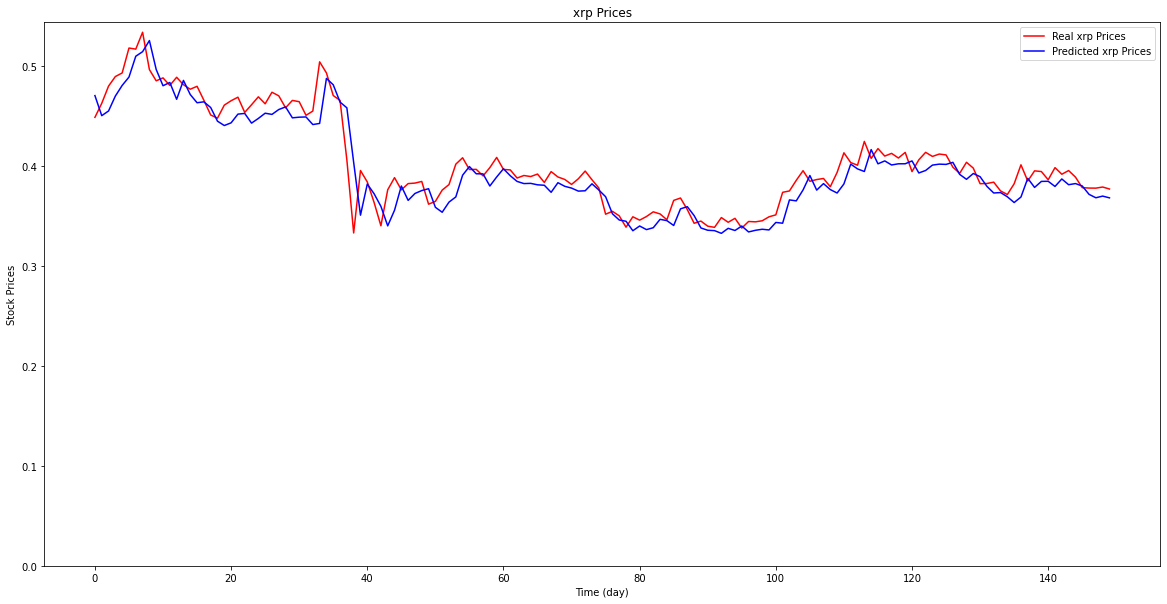

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real xrp Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted xrp Prices")
plt.title(f"xrp Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.01
MAPE: 3.09%
MSE: 0.00
RMSE: 0.02
R2: 0.87


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))